# <b> Higgs Boson Machine Learning Challenge

Higgs Boson Challenge

The Higgs Boson particle was discovered in 2013. A key property of any particle is how often it decays into other particles. ATLAS is a particle physics experiment taking place at the Large Hadron Collider at CERN that searches for new particles and processes using head-on collisions of protons of extraordinarily high energy. The ATLAS experiment has recently observed a signal of the Higgs boson decaying into two tau particles, but this decay is a small signal buried in background noise. 

The goal of the project is to improve the procedure that produces the selection region. We provide a training set with signal/background labels and with weights, a test set (without labels and weights), and a formal objective representing an approximation of the median significance (AMS) of the counting test. 


#### **Project Objective:** 

The objective of the project is to classify an event produced in the particle accelerator as background or signal. As described in the report of the dataset, a background event is explained by the existing theories and previous observations. A signal event, however, indicates a process that cannot be described by previous observations and leads to the potential discovery of a new particle.

#### **Dataset Characteristics**
The dataset from Kaggle has 800000 events (195.5 MB in total):

* Training set of 250000 events
* Test set of 550000 events

Training set has 30 feature columns, a weight column and a label column. Test set has 30 feature columns and a label column.


#### **Feature Characteristics**

* all variables are floating point, except PRI_jet_num which is integer
* variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
* variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS
* it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables
* the weight column is generated by the simulation program that generated this dataset and thus can not be used as a predictor.
* more information about the individual features is available at the technical documentation: https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

#### <b>Outline of this Project
This project has the following flow:

* Preprocessing and Cleaning of the data 
* Exploratory Data Analysis
* Base Model: 
* Ensemble Models: 
* Experimentation: 
* Interpretation: 
* Post modeling, interpret your results. 
* Conclusions: 

The final submission includes video, poster and colab notebook.

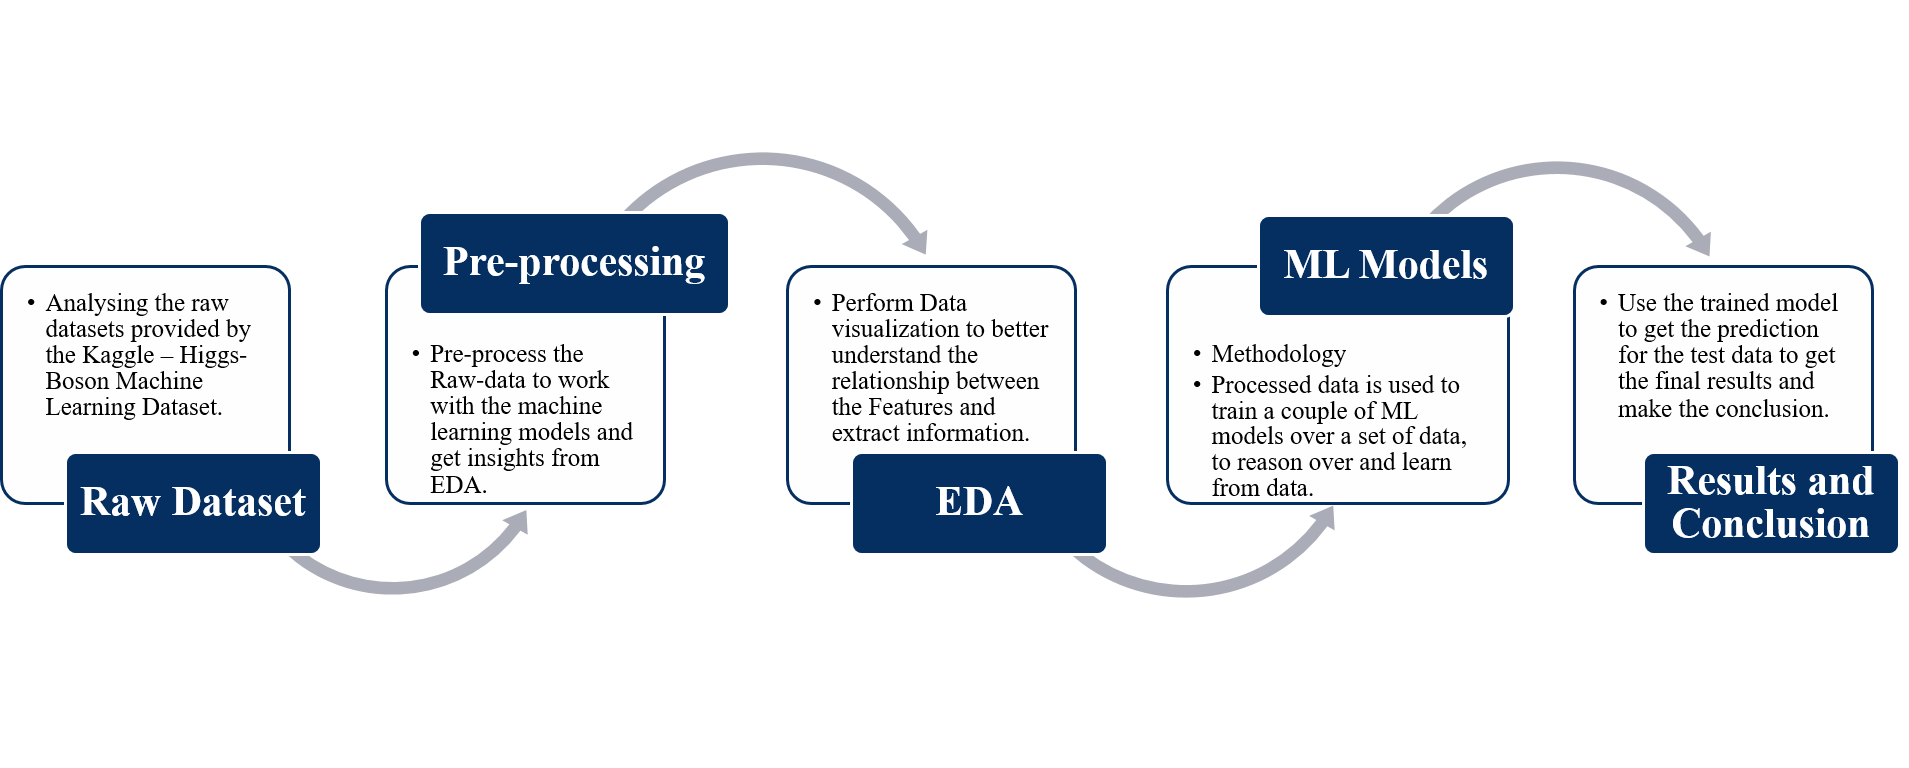

# <b> Importing the Necessary Libraries

In [95]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

import warnings


#### <b> Loading the Training dataset

In [2]:
# Uncomment below line to download the data yourself

#!wget https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_0d3a85c481ad4e7397627de92743d11d.csv  -O training.csv -nv
#!wget https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_16a75379465a4a168be7cf71e2e8145a.csv  -O test.csv -nv
#!wget https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_df53ebd965f949399511db6d73387af7.csv  -O random_submission.csv -nv

2022-06-16 07:03:52 URL:https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_0d3a85c481ad4e7397627de92743d11d.csv [55253673/55253673] -> "training.csv" [1]
2022-06-16 07:03:52 URL:https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_16a75379465a4a168be7cf71e2e8145a.csv [112278440/112278440] -> "test.csv" [1]
2022-06-16 07:03:53 URL:https://71e9c060-1478-4f85-91bf-9f17c1cbb363.usrfiles.com/ugd/71e9c0_df53ebd965f949399511db6d73387af7.csv [9238920/9238920] -> "random_submission.csv" [1]


In [3]:
df_train = pd.read_csv('training.csv')
print(f"Training dataset \nRows :{df_train.shape[0]} ; Columns :{df_train.shape[1]}")
df_train.head()

Training dataset 
Rows :250000 ; Columns :33


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


#### <b> Loading the Test dataset

In [4]:
df_test = pd.read_csv('test.csv')
print(f"Testing dataset \nRows :{df_test.shape[0]} ; Columns :{df_test.shape[1]}")
df_test.head()

Testing dataset 
Rows :550000 ; Columns :31


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [5]:
# Importing random submisions: (This gives the idea and format to submit our final result)
df_random_submission = pd.read_csv('random_submission.csv')
df_random_submission.head()


,EventId,RankOrder,Class
0,350000,416957,b
1,350001,89624,b
2,350002,519845,b
3,350003,510885,s
4,350004,455944,s


# <b> PREPROCESSING:

In [6]:
# Removing EVENT-ID column as it not going to help in modeling in any way 
df_train = df_train.drop("EventId", axis =1)
df_test = df_test.drop("EventId",axis =1)

In [7]:
# Displaying train dataset characteristics
print('Class distribution of the training set is:')
ipd.display(df_train['Label'].value_counts())
print('The label s = signal of Higgs Boson and b = background\n')
ipd.display(df_train.describe())

Class distribution of the training set is:


b    164333
s     85667
Name: Label, dtype: int64

The label s = signal of Higgs Boson and b = background



,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,158.432217,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,115.706115,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.104000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,77.550000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,120.664500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,200.478250,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


The class distribution of the training set is

* b (background) : 164333 events (66%)
* s (Higgs to tau tau): 85667 (34%)

In [8]:
# Doing the ordinal encoding on Label of Train and Random submission dataset: 
# Perfprming ordinal Encoding 
# Label : b =0, s = 1

ord_En = OrdinalEncoder()

ord_Label = ord_En.fit_transform(df_train[['Label']])
ord_class = ord_En.fit_transform(df_random_submission[['Class']])

df_train['Label'] = ord_Label
df_random_submission['Class']= ord_class

In [9]:
# SneakPeek to the Train dataset: 
df_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,1.0
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,0.0
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,0.0
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,0.0
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,0.0


In [10]:
# SneakPeek to the Test dataset: 
df_test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,56.018,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,132.865,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,97.600,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,94.112,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,721.552,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


### Missing Values
-990.0 values represent entries that have no meaning/that could not be calculated. The table below shows the the percentage of those missing values per column.

We can see than there are a lot of missing values: 72% of rows contain at least one missing value and of some columns have up to 71% of them. So it is not viable to delete rows or columns, otherwise it will throw away too much data. Moreover the fact that a variable has no meaning or couldn't be calculated might be correlated with the label.

<b> Getting rid of all -999 values from both of the dataset and replacing them with NaN:

In [11]:
# Getting rid of all -999 values and replce with 'Nan'
df_train = df_train.replace(-999, np.nan)
df_test = df_test.replace(-999.000, np.nan)

# Printing information about percentage of missing values in the training dataset
perc_nans = df_train.isna().sum() * 100 / len(df_train)
perc_rows_nans = (len(df_train) - len(df_train.dropna()))*100/(len(df_train))
print("Percentage of rows containing at least one missing value:", perc_rows_nans)
print('\nTable of column name and percentage missing values')
print(perc_nans)

Percentage of rows containing at least one missing value: 72.7544

Table of column name and percentage missing values
DER_mass_MMC                   15.2456
DER_mass_transverse_met_lep     0.0000
DER_mass_vis                    0.0000
DER_pt_h                        0.0000
DER_deltaeta_jet_jet           70.9828
DER_mass_jet_jet               70.9828
DER_prodeta_jet_jet            70.9828
DER_deltar_tau_lep              0.0000
DER_pt_tot                      0.0000
DER_sum_pt                      0.0000
DER_pt_ratio_lep_tau            0.0000
DER_met_phi_centrality          0.0000
DER_lep_eta_centrality         70.9828
PRI_tau_pt                      0.0000
PRI_tau_eta                     0.0000
PRI_tau_phi                     0.0000
PRI_lep_pt                      0.0000
PRI_lep_eta                     0.0000
PRI_lep_phi                     0.0000
PRI_met                         0.0000
PRI_met_phi                     0.0000
PRI_met_sumet                   0.0000
PRI_jet_num             

In [12]:
# Replacing all nan values with fill forward method 
df_train = df_train.fillna(method= 'ffill')
df_test = df_test.fillna(method= 'bfill')

print("Now, we dont have any 'nan' values in any of the dataset")

Now, we dont have any 'nan' values in any of the dataset


In [13]:
# Lets normalize the whole dataset except for the Weight , LAbel columns:
from sklearn.preprocessing import MinMaxScaler
column = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

df_train[column] = MinMaxScaler().fit_transform(np.array(df_train[column]))
df_test[column] = MinMaxScaler().fit_transform(np.array(df_test[column]))

<b> NOW, we don't have any negative or nan values in our dataset

In [14]:
df_train = round(df_train,2)
df_test = round(df_test,2)

In [15]:
# To check if normalization works or not
print("Pre-Processed Data")
df_train.head()

Pre-Processed Data


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,0.11,0.07,0.07,0.01,0.11,0.02,0.6,0.52,0.01,0.08,...,2,0.03,0.74,0.57,0.02,0.64,0.11,0.07,0.00,1.0
1,0.13,0.10,0.07,0.02,0.11,0.02,0.6,0.60,0.00,0.04,...,1,0.01,0.58,0.68,0.02,0.64,0.11,0.03,2.23,0.0
2,0.13,0.24,0.09,0.01,0.11,0.02,0.6,0.54,0.00,0.08,...,1,0.01,0.73,0.18,0.02,0.64,0.11,0.03,2.35,0.0
3,0.11,0.12,0.06,0.00,0.11,0.02,0.6,0.57,0.00,0.02,...,0,0.01,0.73,0.18,0.02,0.64,0.11,0.00,5.45,0.0
4,0.14,0.02,0.10,0.01,0.11,0.02,0.6,0.67,0.01,0.01,...,0,0.01,0.73,0.18,0.02,0.64,0.11,0.00,6.25,0.0


In [16]:
df_test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,0.05,0.08,0.01,0.00,0.15,0.11,0.51,0.12,0.00,0.00,...,0.82,0.04,0,0.02,0.44,0.36,0.2,0.54,0.91,0.00
1,0.05,0.07,0.06,0.04,0.15,0.11,0.51,0.33,0.00,0.04,...,0.32,0.07,1,0.02,0.44,0.36,0.2,0.54,0.91,0.03
2,0.06,0.06,0.07,0.00,0.15,0.11,0.51,0.46,0.01,0.03,...,0.20,0.04,0,0.20,0.39,0.45,0.2,0.54,0.91,0.00
3,0.07,0.03,0.07,0.01,0.15,0.11,0.51,0.47,0.01,0.02,...,0.69,0.07,0,0.20,0.39,0.45,0.2,0.54,0.91,0.00
4,0.03,0.09,0.04,0.07,0.15,0.11,0.51,0.14,0.10,0.33,...,0.46,0.39,3,0.20,0.39,0.45,0.2,0.54,0.91,0.32


In [17]:
# Statistical description of numerical variables in the test set
df_train.describe()


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.095331,0.071315,0.055744,0.020232,0.282501,0.071971,0.496236,0.395370,0.006363,0.062179,...,0.979176,0.049900,0.499645,0.497887,0.039835,0.498920,0.500296,0.044682,1.646026,0.342668
std,0.048489,0.051360,0.030540,0.022766,0.204768,0.079975,0.103219,0.142998,0.008501,0.064118,...,0.977426,0.055516,0.198067,0.288763,0.046420,0.225511,0.288745,0.060066,1.875466,0.474603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.070000,0.030000,0.040000,0.000000,0.100000,0.020000,0.440000,0.290000,0.000000,0.020000,...,0.000000,0.010000,0.350000,0.250000,0.010000,0.320000,0.250000,0.000000,0.020000,0.000000
50%,0.090000,0.070000,0.050000,0.010000,0.250000,0.040000,0.510000,0.420000,0.000000,0.040000,...,1.000000,0.030000,0.500000,0.490000,0.030000,0.500000,0.500000,0.020000,1.160000,0.000000
75%,0.110000,0.110000,0.060000,0.030000,0.430000,0.090000,0.550000,0.500000,0.010000,0.090000,...,2.000000,0.070000,0.650000,0.750000,0.050000,0.680000,0.750000,0.070000,2.400000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.820000,1.000000


# <b> Performing Exploratory Data Analysis (EDA):

<b> Creating a new train and test dataset, so it will not interfere with our Original Dataset:

Note: the weight column is generated by the simulation program that generated this dataset and thus can not be used as a predictor.

In [18]:
# Droping the Weight Column, as we don't have the weight column in TEST DATASET.
df_train_new = df_train.drop("Weight",axis =1)
df_train_new.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,0.11,0.07,0.07,0.01,0.11,0.02,0.6,0.52,0.01,0.08,...,0.12,2,0.03,0.74,0.57,0.02,0.64,0.11,0.07,1.0
1,0.13,0.10,0.07,0.02,0.11,0.02,0.6,0.60,0.00,0.04,...,0.08,1,0.01,0.58,0.68,0.02,0.64,0.11,0.03,0.0
2,0.13,0.24,0.09,0.01,0.11,0.02,0.6,0.54,0.00,0.08,...,0.12,1,0.01,0.73,0.18,0.02,0.64,0.11,0.03,0.0
3,0.11,0.12,0.06,0.00,0.11,0.02,0.6,0.57,0.00,0.02,...,0.04,0,0.01,0.73,0.18,0.02,0.64,0.11,0.00,0.0
4,0.14,0.02,0.10,0.01,0.11,0.02,0.6,0.67,0.01,0.01,...,0.02,0,0.01,0.73,0.18,0.02,0.64,0.11,0.00,0.0


To get a better understanding of the features' distributions we plot the histograms for each feature.

Some variables seem to follow well known probability distributions:

* Gaussian (ex. PRI_tau_eta, PRI_lep_eta)
* Beta distribution with one parameter alpha (U distribution) (DER_lep_eta_centrality, DER_met_phi_centrality)
* Uniform distributions (ex. PRI_tau_phi, PRI_met_phi)
* Exponential distributions (ex. DER_sum_pt, PRI_jet_leading_pt)

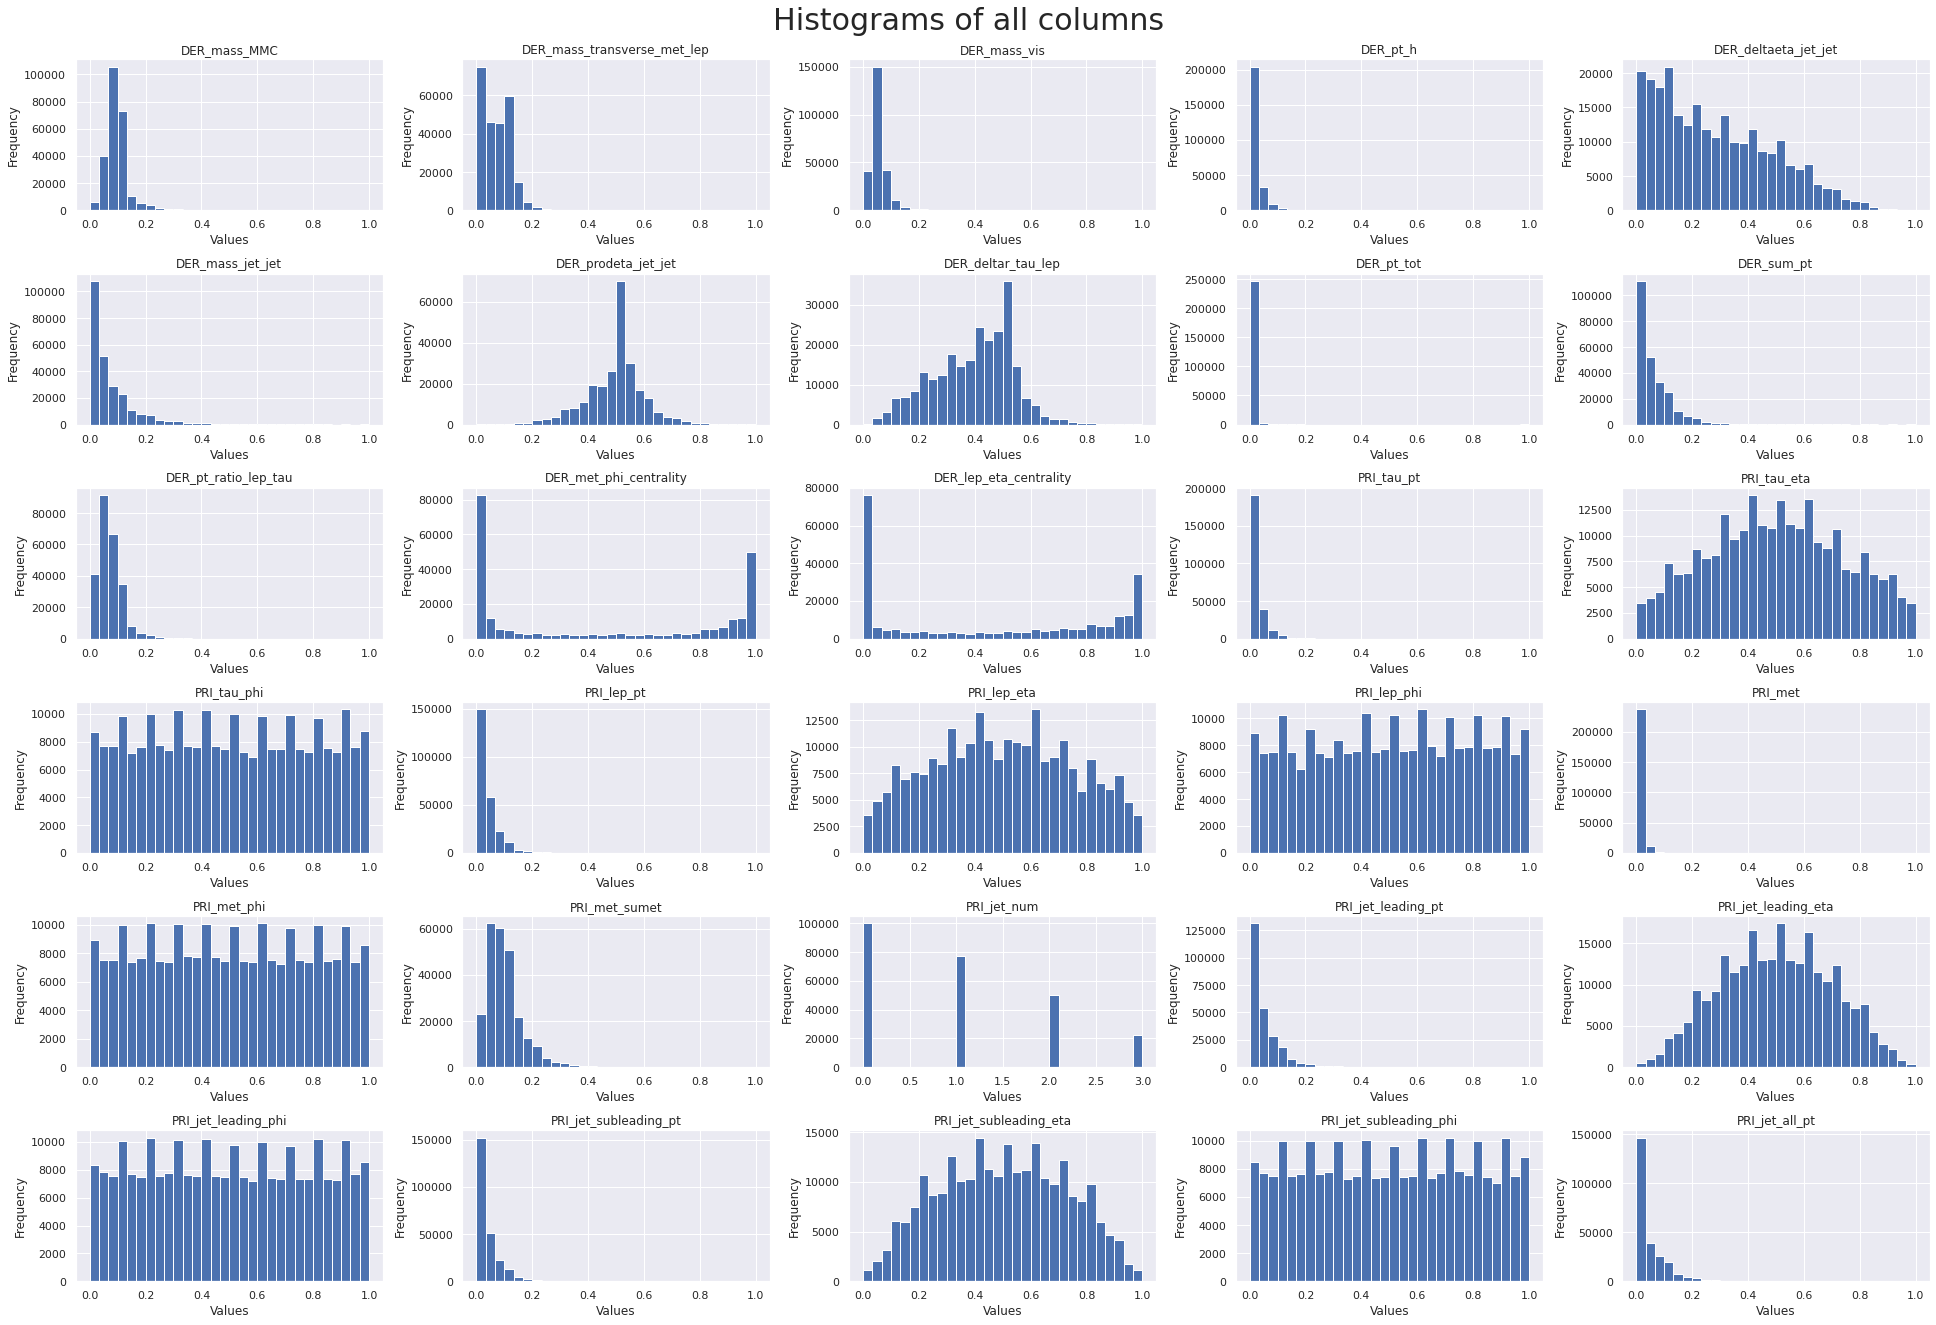

In [19]:
# show histograms of features
a = df_train_new.drop('Label', axis = 1).hist(bins=30, figsize=(27,18))
plt.suptitle("Histograms of all columns", fontsize=30, y = 1.02)
for fig in a.flatten():
    fig.set_xlabel('Values')
    fig.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

* <b> Plotting the co-relation matrix:

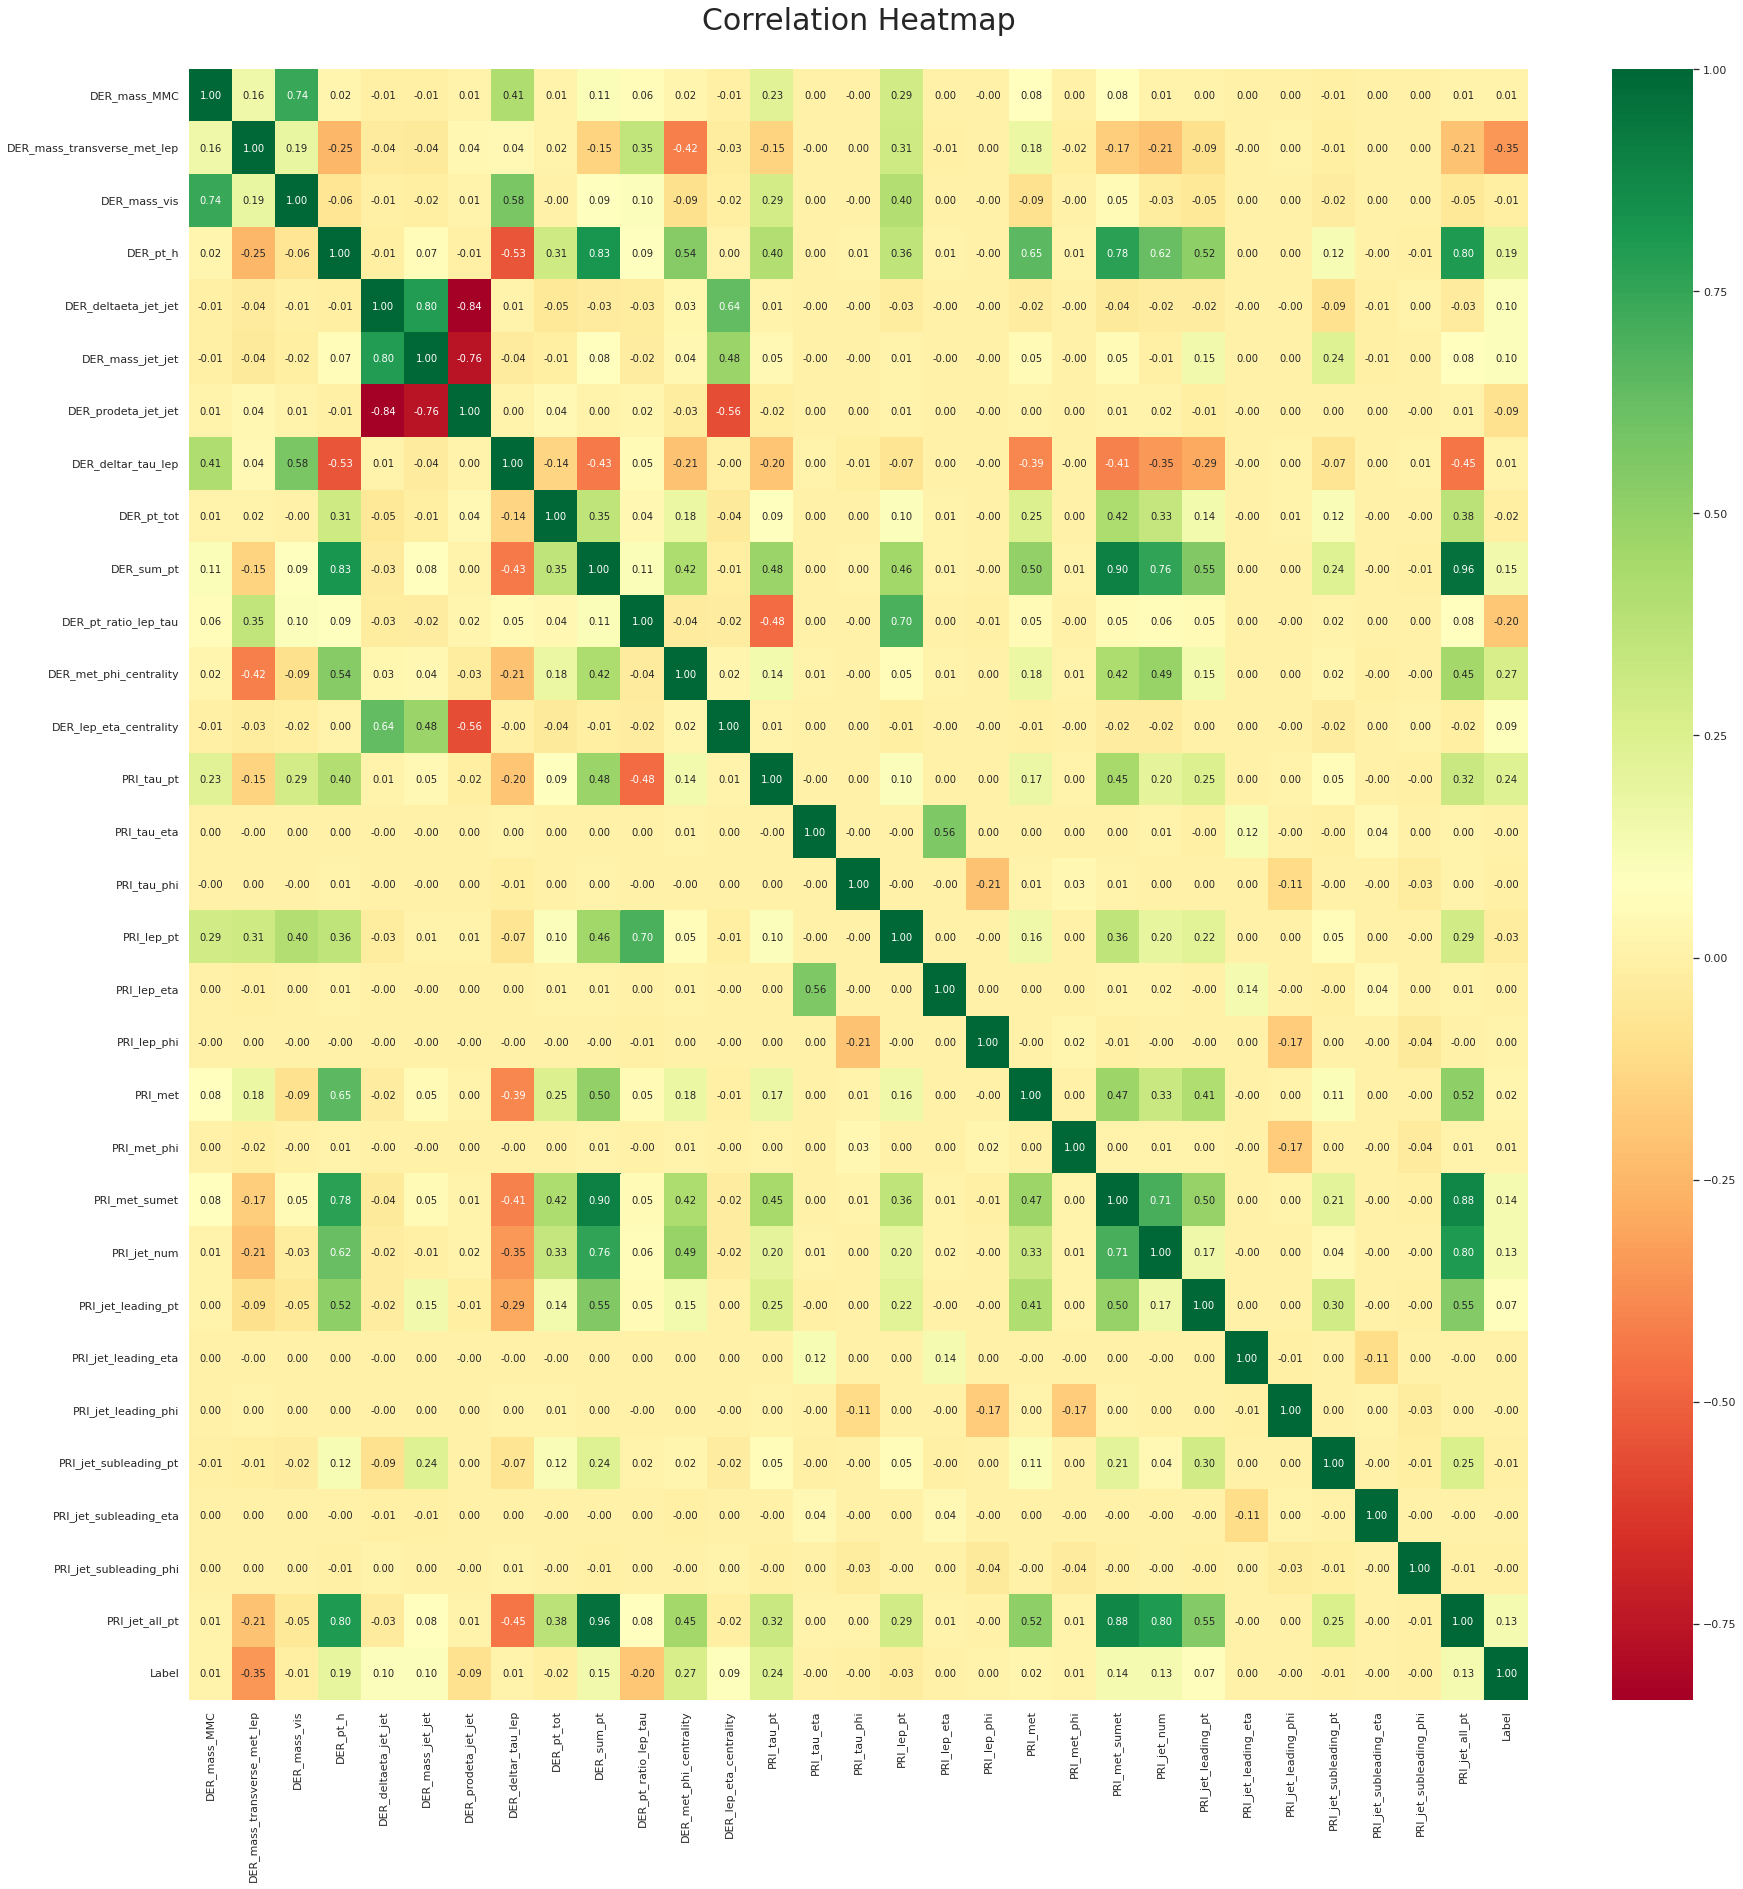

In [20]:
# Plotting the heat map of correlation matrix using seaborn :
plt.figure(figsize= (30,30))
sns.heatmap(df_train_new.corr(), annot = True, cmap='RdYlGn', fmt='.2f')
plt.title("Correlation Heatmap\n", fontsize=30)
plt.show()

<b> Observation:  From this correlation matrix, we can filterout the significant features affecting our Response Variable (Threshold > 0.1 for positive and < -0.1 for negative): 

Features affecting our Response variables are:
 
 DER_mass_transverse_met_lep, DER_pt_h , DER_sum_pt , DER_met_phi_centrality , PRI_tau_pt , PRI_met_sumet , PRI_jet_num, PRI_jet_all_pt.


* #### <b> Constructing barplot and donutplot of our dataframe columns 

In [21]:
# Function to construct barplot and donutplot of a dataframe column
def bar_donut(df, col, h = 500, w = 800):
    fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'xy'}, {'type': 'domain'}]])
    x_val, y_val = df[col].value_counts(sort = False).index.tolist(), df[col].value_counts(sort = False).tolist()
    fig.add_trace(go.Bar(x = x_val, y = y_val, text = y_val, textposition = 'auto'), row = 1, col = 1)
    fig.add_trace(go.Pie(values = y_val, labels = x_val, hole = 0.5, textinfo = 'label+percent', title = f"{col}"), row = 1, col = 2)
    fig.update_layout(height = h, width = w, showlegend = True, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = f"Frequency distribution of {col}", x = 0.5, y = 0.95)) 
    fig.show()

In [22]:
# Target variable
from plotly.subplots import make_subplots
import plotly.graph_objects as go
bar_donut(df_train_new, 'Label')

<b> Observation: From the above subplots we can say that most of the labels are background noises instead of actual signals. 

* #### <b> Comparison of Feature distribution for the training set and the test set.

First we check the distributions of the features for the training set and the test set. If we are to train our model on one set (the training set) and use it to make predictions on another (the test set), then it is desirable that the distributions corresponding to the two sets have similar structure.

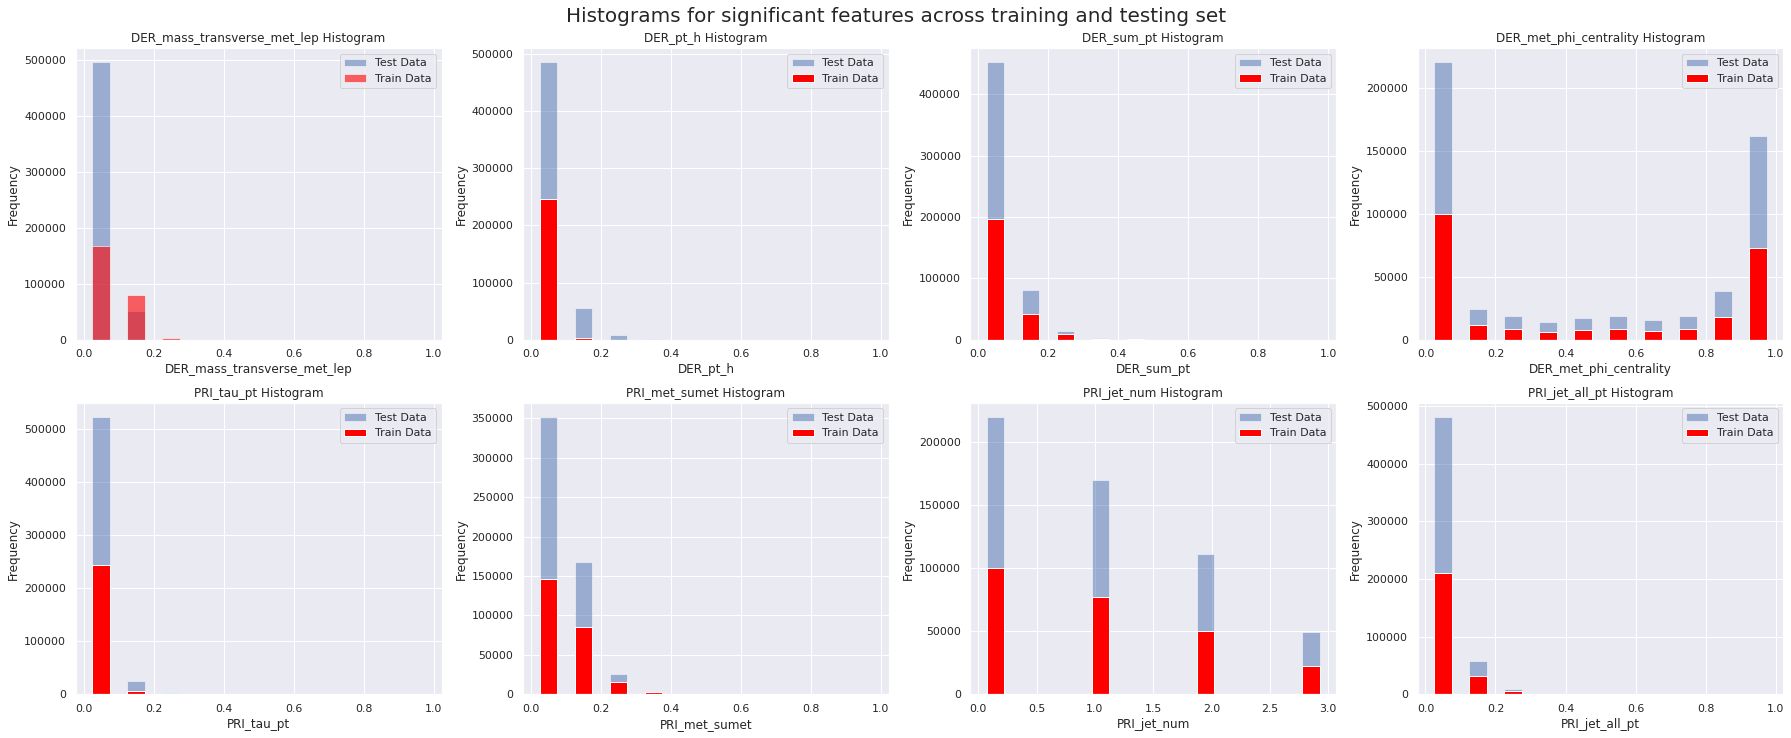

In [88]:
columns= ['DER_mass_transverse_met_lep', 'DER_pt_h' , 'DER_sum_pt' , 'DER_met_phi_centrality' , 'PRI_tau_pt' , 'PRI_met_sumet' , 'PRI_jet_num','PRI_jet_all_pt']

fig , ax = plt.subplots(2,4, figsize = (25,10))
fig.suptitle('Histograms for significant features across training and testing set', fontsize=20, y = 1.02)
ax[0][0].hist(df_test['DER_mass_transverse_met_lep'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[0][0].hist(df_train_new['DER_mass_transverse_met_lep'], label = 'Train Data', alpha = 0.6,rwidth= 0.5, color = 'RED')
ax[0][0].set_xlabel('DER_mass_transverse_met_lep'); ax[0][0].set_ylabel('Frequency')
ax[0][0].set_title("DER_mass_transverse_met_lep Histogram")
ax[0][0].legend()


ax[0][1].hist(df_test['DER_pt_h'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[0][1].hist(df_train_new['DER_pt_h'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[0][1].set_xlabel('DER_pt_h'); ax[0][1].set_ylabel('Frequency')
ax[0][1].set_title("DER_pt_h Histogram")
ax[0][1].legend()


ax[0][2].hist(df_test['DER_sum_pt'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[0][2].hist(df_train_new['DER_sum_pt'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[0][2].set_xlabel('DER_sum_pt'); ax[0][2].set_ylabel('Frequency')
ax[0][2].set_title("DER_sum_pt Histogram")
ax[0][2].legend()


ax[0][3].hist(df_test['DER_met_phi_centrality'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[0][3].hist(df_train_new['DER_met_phi_centrality'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[0][3].set_xlabel('DER_met_phi_centrality'); ax[0][3].set_ylabel('Frequency')
ax[0][3].set_title("DER_met_phi_centrality Histogram")
ax[0][3].legend()


ax[1][0].hist(df_test['PRI_tau_pt'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[1][0].hist(df_train_new['PRI_tau_pt'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][0].set_xlabel('PRI_tau_pt'); ax[1][0].set_ylabel('Frequency')
ax[1][0].set_title("PRI_tau_pt Histogram")
ax[1][0].legend()

ax[1][1].hist(df_test['PRI_met_sumet'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[1][1].hist(df_train_new['PRI_met_sumet'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][1].set_xlabel('PRI_met_sumet'); ax[1][1].set_ylabel('Frequency')
ax[1][1].set_title("PRI_met_sumet Histogram")
ax[1][1].legend()

ax[1][2].hist(df_test['PRI_jet_num'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[1][2].hist(df_train_new['PRI_jet_num'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][2].set_xlabel('PRI_jet_num'); ax[1][2].set_ylabel('Frequency')
ax[1][2].set_title("PRI_jet_num Histogram")
ax[1][2].legend()

ax[1][3].hist(df_test['PRI_jet_all_pt'], label = 'Test Data', alpha = 0.5,rwidth= 0.5)
ax[1][3].hist(df_train_new['PRI_jet_all_pt'], label = 'Train Data', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][3].set_xlabel('PRI_jet_all_pt'); ax[1][3].set_ylabel('Frequency')
ax[1][3].set_title("PRI_jet_all_pt Histogram")
ax[1][3].legend()


fig.tight_layout()
fig.show()

<b> Observation:  we can observe that the distributions corresponding to the two sets have almost similar structure.

* #### <b> Comparison of feature distributions by target class  "b"  or  "s" in the training set

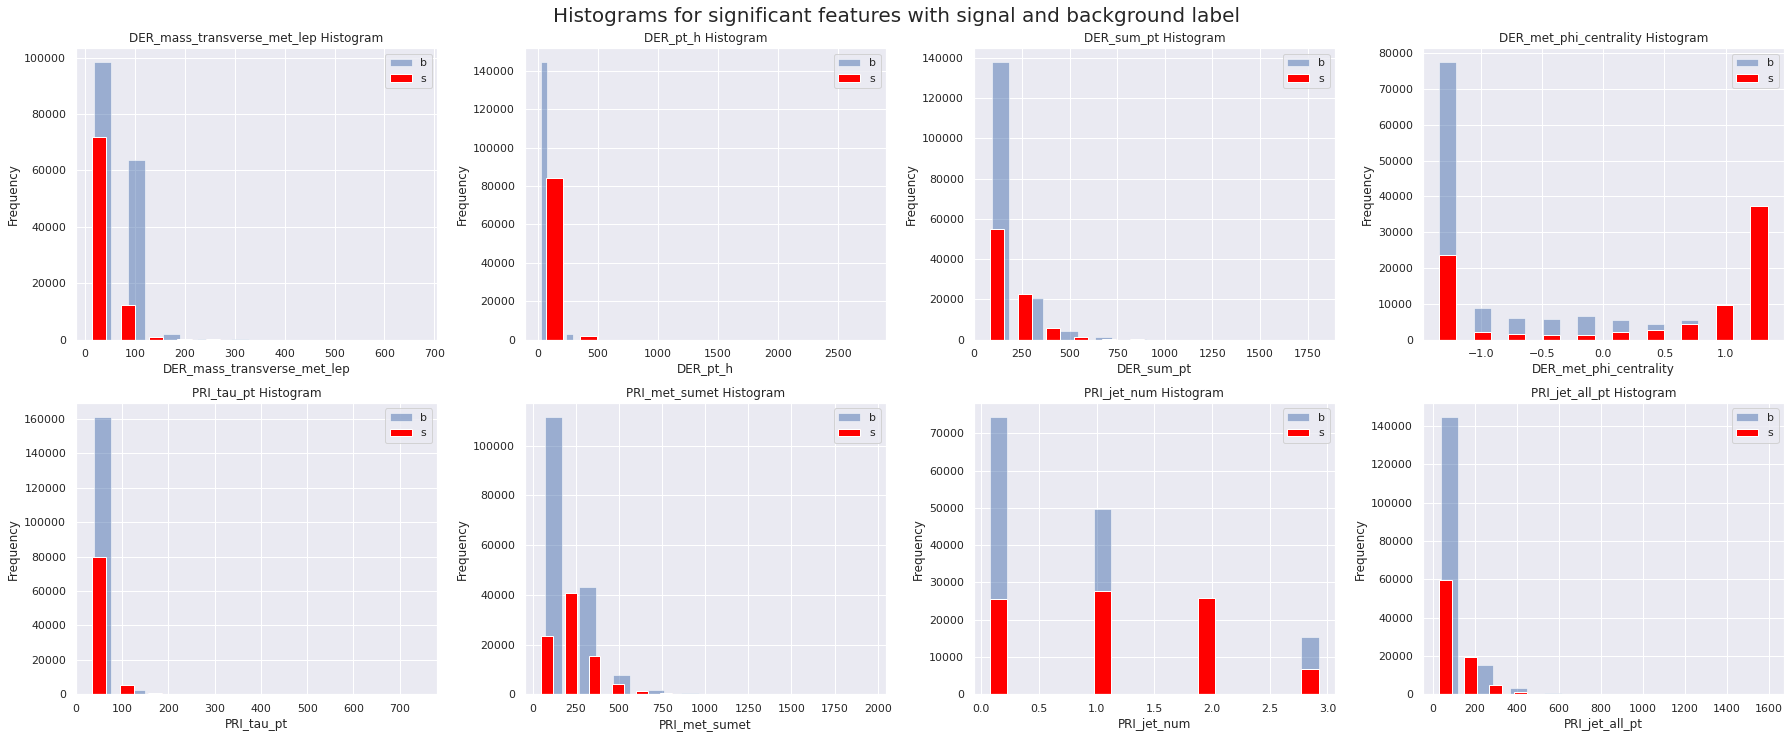

In [90]:
columns= ['DER_mass_transverse_met_lep', 'DER_pt_h' , 'DER_sum_pt' , 'DER_met_phi_centrality' , 'PRI_tau_pt' , 'PRI_met_sumet' , 'PRI_jet_num','PRI_jet_all_pt']
df_train_new_1 = pd.read_csv("training.csv") # Directly visualizing the original dataset
fig , ax = plt.subplots(2,4, figsize = (25,10))
fig.suptitle('Histograms for significant features with signal and background label', fontsize=20, y = 1.02)

ax[0][0].hist(df_train_new_1['DER_mass_transverse_met_lep'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[0][0].hist(df_train_new_1['DER_mass_transverse_met_lep'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5, color = 'RED')
ax[0][0].set_xlabel('DER_mass_transverse_met_lep'); ax[0][0].set_ylabel('Frequency')
ax[0][0].set_title("DER_mass_transverse_met_lep Histogram")
ax[0][0].legend()

ax[0][1].hist(df_train_new_1['DER_pt_h'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5, rwidth= 0.5)
ax[0][1].hist(df_train_new_1['DER_pt_h'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1, rwidth= 0.5,color = 'RED')
ax[0][1].set_xlabel('DER_pt_h'); ax[0][1].set_ylabel('Frequency')
ax[0][1].set_title("DER_pt_h Histogram")
ax[0][1].legend()


ax[0][2].hist(df_train_new_1['DER_sum_pt'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[0][2].hist(df_train_new_1['DER_sum_pt'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[0][2].set_xlabel('DER_sum_pt'); ax[0][2].set_ylabel('Frequency')
ax[0][2].set_title("DER_sum_pt Histogram")
ax[0][2].legend()


ax[0][3].hist(df_train_new_1['DER_met_phi_centrality'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[0][3].hist(df_train_new_1['DER_met_phi_centrality'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[0][3].set_xlabel('DER_met_phi_centrality'); ax[0][3].set_ylabel('Frequency')
ax[0][3].set_title("DER_met_phi_centrality Histogram")
ax[0][3].legend()


ax[1][0].hist(df_train_new_1['PRI_tau_pt'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[1][0].hist(df_train_new_1['PRI_tau_pt'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][0].set_xlabel('PRI_tau_pt'); ax[1][0].set_ylabel('Frequency')
ax[1][0].set_title("PRI_tau_pt Histogram")
ax[1][0].legend()

ax[1][1].hist(df_train_new_1['PRI_met_sumet'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[1][1].hist(df_train_new_1['PRI_met_sumet'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][1].set_xlabel('PRI_met_sumet'); ax[1][1].set_ylabel('Frequency')
ax[1][1].set_title("PRI_met_sumet Histogram")
ax[1][1].legend()

ax[1][2].hist(df_train_new_1['PRI_jet_num'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[1][2].hist(df_train_new_1['PRI_jet_num'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][2].set_xlabel('PRI_jet_num'); ax[1][2].set_ylabel('Frequency')
ax[1][2].set_title("PRI_jet_num Histogram")
ax[1][2].legend()

ax[1][3].hist(df_train_new_1['PRI_jet_all_pt'][df_train_new_1["Label"] == 'b'], label = 'b', alpha = 0.5,rwidth= 0.5)
ax[1][3].hist(df_train_new_1['PRI_jet_all_pt'][df_train_new_1["Label"] == 's'], label = 's', alpha = 1,rwidth= 0.5,color = 'RED')
ax[1][3].set_xlabel('PRI_jet_all_pt'); ax[1][3].set_ylabel('Frequency')
ax[1][3].set_title("PRI_jet_all_pt Histogram")
ax[1][3].legend()

fig.tight_layout()
fig.show()

<b> Observation : We compared the distributions of the features for the background events and the signal events in the training set. If a feature has reasonably different distributions corresponding to the background events and the signal events, then it is a clear indication that the feature is important in the task of classifying the events when the label is unknown. Similarly, if a feature has very similar distributions for the two target classes, then it is unlikely to help in the classification problem based on the feature alone. This, however, does not take into account the possible dependence the feature may have with other features which may turn out to be useful in the task of classification. To neglect the possiblilty of that, we will do our modeling on the whole dataset instead of signinficant features only.

* #### <b> Donutplots for Frequency comparison of 'Number of Jets'

In [25]:
# function to plot donutplots 
def donut(df1, df2, col,text1, text2, title_text = "Title"):
    fig = make_subplots(rows = 1, cols = 2, column_widths = [0.5, 0.5], row_heights = [0.5], specs = [[ {"type": "pie"}, {"type": "pie"}]])
    fig.add_trace(go.Pie(labels = df1[col].value_counts().index, values = df1[col].value_counts(), legendgroup = "group", textinfo = 'percent', hole = 0.3, title = dict(text = text1)), row = 1, col = 1)
    fig.add_trace(go.Pie(labels = df2[col].value_counts().index, values = df2[col].value_counts(), legendgroup = "group", textinfo = 'percent', hole = 0.3, title = dict(text = text2)), row = 1, col = 2)
    fig.update_layout(title = dict(text = title_text, y = 0.9, x = 0.5, xanchor = 'center', yanchor = 'top'))
    fig.show()

In [26]:
# Frequency comparison of PRI_jet_num for the training set and the test set
donut(df_train, df_test, col = 'PRI_jet_num', text1 = 'Train', text2 = 'Test', title_text = "Frequency comparison of PRI_jet_num for Train and Test dataset")

<b> Observation: The proportions of values of PRI_jet_num are more or less same for both the training set and the test set

In [27]:
# Frequency comparison of PRI_jet_num for the background events and the signal events in the training set
donut(df_train[df_train["Label"] == 0], df_train[df_train["Label"] == 1], col = 'PRI_jet_num', text1 = 'Background', text2 = 'Signal', title_text = "Frequency comparison of PRI_jet_num in the training set by target class")

<b> Observation: The proportions of values of PRI_jet_num, especially 0 and 2 , differ for the background events and the signal events in the training set.

* #### <b>  Correlation heatmap of float features for background events and signal events in the training set

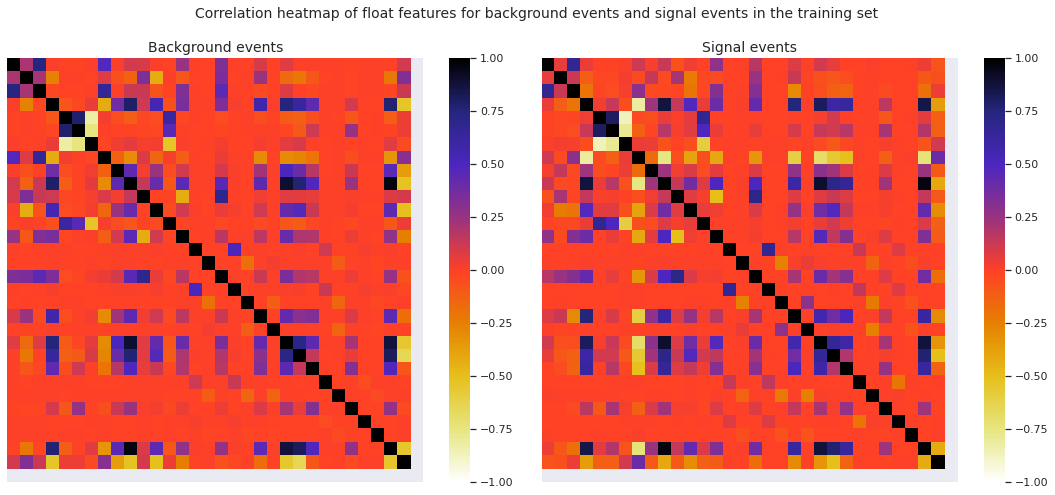

In [28]:
# Correlation heatmap of float features for background events and signal events in the training set
fig, ax = plt.subplots(1, 2, figsize = (15, 6.5), sharex = True, sharey = True)
sns.heatmap(df_train[df_train["Label"] == 0].corr(), vmin = -1, vmax = 1, annot = False, xticklabels = False, yticklabels = False, cmap = plt.cm.CMRmap_r, ax = ax[0])
sns.heatmap(df_train[df_train["Label"] == 1].corr(), vmin = -1, vmax = 1, annot = False, xticklabels = False, yticklabels = False, cmap = plt.cm.CMRmap_r, ax = ax[1])
ax[0].set_title("Background events", fontsize = 14)
ax[1].set_title("Signal events", fontsize = 14)
plt.suptitle("Correlation heatmap of float features for background events and signal events in the training set", fontsize = 14, y = 1.05)
plt.tight_layout()
plt.show()

<b> Observation: The two heatmaps are more or less similar, i.e. the overall correlation structure of the features corresponding to the background events and the signal events in the training set are very much alike.

# <b> Preparing the Predictors and Response Variable For different ML Algorithms:

In [29]:
# Assigning the predictor and Response Features / Variables
x = df_train.drop(["Label","Weight"],axis =1)
y = df_train["Label"]

In [30]:
# Train-Test Split from the training data: 
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size= 0.75, random_state= 44) 

# <b> Using Logistic regression for BaseLine Model

In [31]:
# Inicialization of Logistic REgression
log_re= LogisticRegression (max_iter= 500)
log_re.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [32]:
# Predicting on the test set:
y_pred_logre = log_re.predict(x_test)

In [33]:
# Calculating the accuracy score: 
acc_logre = accuracy_score(y_pred_logre, y_test)
print("The Accuracy Score  of the Logistic regression Model is :", acc_logre.round(decimals = 2)*100,"%")

The Accuracy Score  of the Logistic regression Model is : 74.0 %


In [34]:
# Cakculating the f1 Score : 
f1_logre = f1_score(y_pred_logre, y_test)
print(f"The  f1 score of the model is: {f1_logre.round(decimals = 2)*100}%")

The  f1 score of the model is: 56.99999999999999%


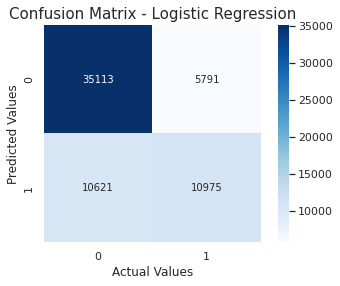

In [35]:
# Plotting the confusion matrix using Seaborn SNS: 
sns.heatmap(confusion_matrix(y_test,y_pred_logre), square=True, annot=True, fmt='d', cmap = "Blues")
plt.title("Confusion Matrix - Logistic Regression", fontsize =15)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [36]:
# Getting the classificaation report : 

report_logre = classification_report(y_test,y_pred_logre, target_names = ['b','s'])
print(report_logre)

              precision    recall  f1-score   support

           b       0.77      0.86      0.81     40904
           s       0.65      0.51      0.57     21596

    accuracy                           0.74     62500
   macro avg       0.71      0.68      0.69     62500
weighted avg       0.73      0.74      0.73     62500



# <b> INITIALIZING THE DECISION TREE MODEL : 


<b> Trying to get the best possible degree for the model

In [37]:
# DECISION TREE MODEL: (To get the best possible degree)
degree = np.arange(1,51)
f1_list = []
acc_list= []
# Import Decision Tree Classifier: 
from sklearn.tree import DecisionTreeClassifier

for i in degree: 
    dct = DecisionTreeClassifier(max_depth = i)
    dct.fit(x_train,y_train)

    #  Predicting on the validation set;
    y_pred_dct = dct.predict(x_test)

    # Getting the accuracy score: 
    acc_dct = round(accuracy_score(y_pred_dct, y_test),4)
    acc_list.append(acc_dct)

    # CAlculating the F1 score: 
    F1_score_dct = f1_score(y_test,y_pred_dct)
    f1_list.append(F1_score_dct)



In [38]:
# Fetching the best depth corrosponds to best f1 value fromt the F1_list.
best_depth_f1 = degree[np.argmax(f1_list)]
print (f"The best degree corrosponds to the best f1 score: {best_depth_f1}")

The best degree corrosponds to the best f1 score: 11


In [39]:
# Initializing the Decision Tree Model With max_depth as 11
dct = DecisionTreeClassifier(max_depth = best_depth_f1)
dct.fit(x_train, y_train)

# Predicting on the validation set: 
y_pred_dct = dct.predict(x_test)

In [40]:
# Calculating the accuracy score: 
acc_dct = accuracy_score(y_pred_dct, y_test)
print("The Accuracy Score  of the Decision Tree Model is :", acc_dct.round(decimals = 2)*100,"%")

The Accuracy Score  of the Decision Tree Model is : 82.0 %


In [41]:
# Cakculating the f1 Score : 
f1_dct = f1_score(y_pred_dct, y_test)
print(f"The  f1 score of the model is: {f1_dct.round(decimals = 2)*100}%")

The  f1 score of the model is: 73.0%


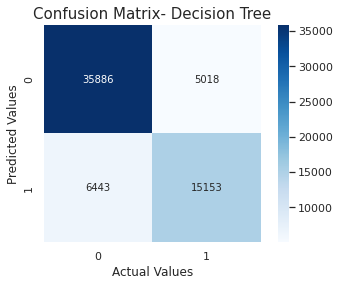

In [42]:
# Plotting the confusion matrix using Seaborn SNS: 
sns.heatmap(confusion_matrix(y_test,y_pred_dct), square=True, annot=True, fmt='d', cmap = "Blues")
plt.title("Confusion Matrix- Decision Tree", fontsize =15)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [43]:
# Getting the classificaation report : 

report_dct = classification_report(y_test,y_pred_dct, target_names = ['b','s'])
print(report_dct)

              precision    recall  f1-score   support

           b       0.85      0.88      0.86     40904
           s       0.75      0.70      0.73     21596

    accuracy                           0.82     62500
   macro avg       0.80      0.79      0.79     62500
weighted avg       0.81      0.82      0.82     62500



<b> Visualizing the DECISION TREE:

In [94]:
from sklearn import tree

# Code to set the size of the plot
plt.figure(figsize=(100,12), dpi = 150)

# Plot the Decision Tree trained above with parameters filled as True
tree.plot_tree(dct, filled = True, fontsize = 5)


plt.show();

Output hidden; open in https://colab.research.google.com to view.

# <b> INITIALIZING ENSEMBLE MODEL: RANDOM FOREST

<b> We are going to balance the class imbalance in each bootstrap: 

In [45]:
# Set the maximum depth to be 11 (calculated in above step) and use 10 estimators and random state as 44
# Use class_weight as balanced_subsample to weigh the class accordingly
forest = RandomForestClassifier(n_estimators =10, max_depth = 11 , class_weight = 'balanced_subsample', random_state =44)

# Fitting the model:
forest.fit(x_train,y_train)

# Gettin the Predictions: 
y_pred_forest = forest.predict(x_test)

In [46]:
# Calculating the accuracy score: 
acc_forest = accuracy_score(y_pred_forest, y_test)
print("The Accuracy Score  of the Decision Tree Model is :", acc_forest.round(decimals = 2)*100,"%")

The Accuracy Score  of the Decision Tree Model is : 81.0 %


In [47]:
# Cakculating the f1 Score : 
f1_forest = f1_score(y_pred_forest, y_test)
print(f"The  f1 score of the model is: {f1_forest.round(decimals = 2)*100}%")

The  f1 score of the model is: 75.0%


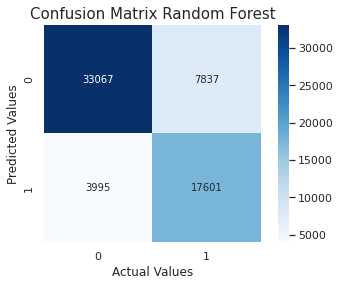

In [48]:
# Plotting the confusion matrix using Seaborn SNS: 
sns.heatmap(confusion_matrix(y_test,y_pred_forest), square=True, annot=True, fmt='d', cmap = "Blues")
plt.title("Confusion Matrix Random Forest", fontsize =15)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [49]:
# Getting the classificaation report : 

report_forest = classification_report(y_test,y_pred_forest, target_names = ['b','s'])
print(report_forest)

              precision    recall  f1-score   support

           b       0.89      0.81      0.85     40904
           s       0.69      0.82      0.75     21596

    accuracy                           0.81     62500
   macro avg       0.79      0.81      0.80     62500
weighted avg       0.82      0.81      0.81     62500



We train a random forest to get a scores of features importances.

For each decision tree, the importance of a feature importance is computed as the (normalized) total reduction of the Gini criterion brought by that feature. It is also known as the Gini importance. It follows that the importances of features for the random forest are the mean of those importances for each tree.

Feature ranking:


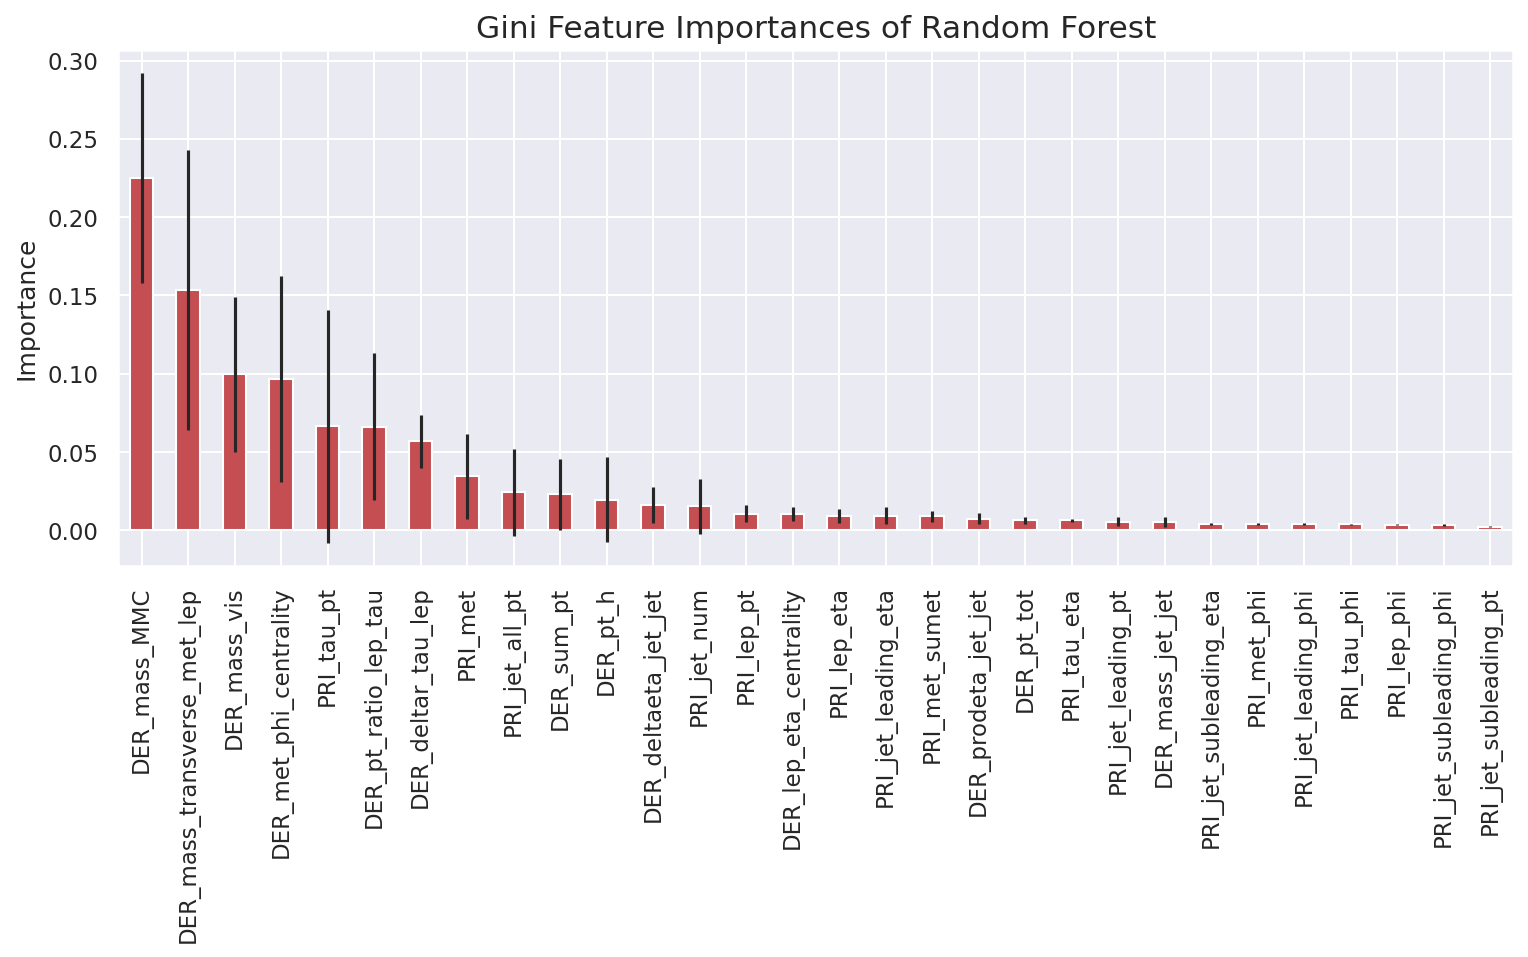

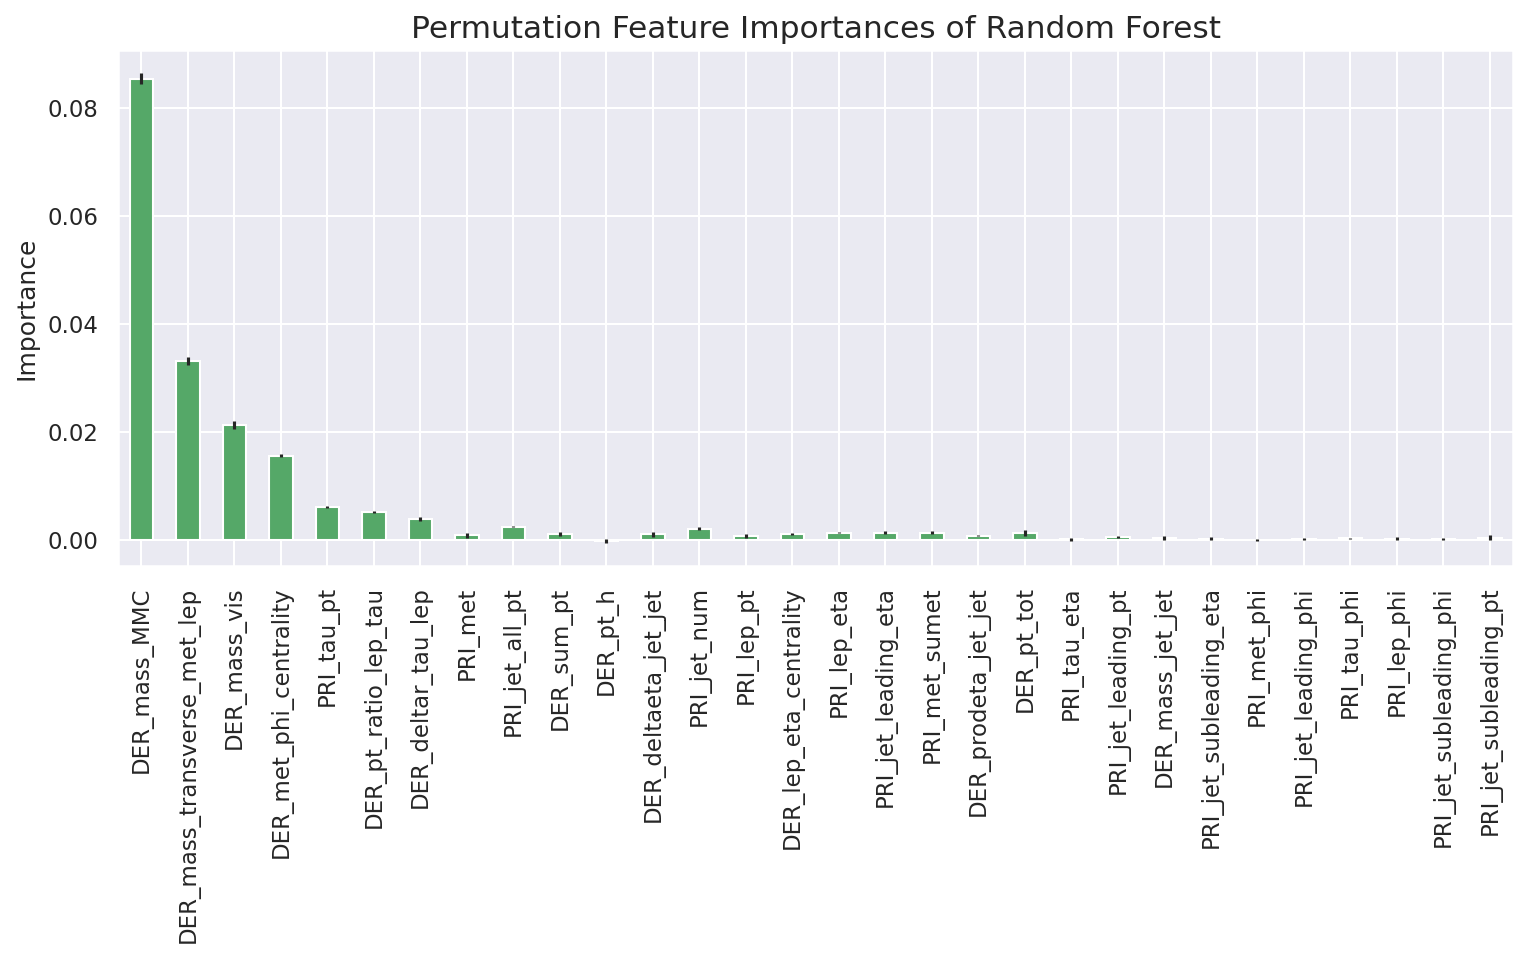

In [101]:
# Analysis of feature importance
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)[indices]

permut_imp = permutation_importance(forest, x_test, y_test)
# Print the feature ranking
print("Feature ranking:")
importances = pd.Series(forest.feature_importances_, index=x_train.columns)[indices]
permut_importances = pd.Series(permut_imp.importances_mean, index=x_train.columns)[indices]

# Plot the feature importances of the forest
plt.figure(figsize=(12,8), dpi = 150)
plt.title("Gini Feature Importances of Random Forest", fontsize=15)
plt.ylabel('Importance')

importances.plot.bar(yerr=std, color='r', label = 'Gini')
plt.gcf().subplots_adjust(bottom=0.45)

plt.show()

plt.figure(figsize=(12,8), dpi = 150)
plt.title("Permutation Feature Importances of Random Forest", fontsize=15)
plt.ylabel('Importance')

permut_importances.plot.bar(yerr=permut_imp.importances_std, color = 'g', label = 'Permutation')
# plt.legend(loc = 'best')
plt.gcf().subplots_adjust(bottom=0.45)

plt.show()


**It can be observed** that except for PRI_met_sumet, all features which were found to be significant according to the correlation heatmat (|correlation| > 0.1) i.e. DER_mass_transverse_met_lep, DER_pt_h, DER_sum_pt, DER_met_phi_centrality, PRI_tau_pt,  PRI_jet_num, PRI_jet_all_pt. are in the top 10 according to the Gini importance.

**Interestingly**, DER_mass_MMC which shows very high importance in both cases is not significant according to the heatmap. This could be because correlation heatmap only looks at linear and inverse correlation, none of which HAVE to be the case for an important feature.


# <b> Plotting ROC Curve and Calculating roc_auc_score 

In [51]:
# Calculating ROC_AUC score

#use models to predict probability that given y value as 1
y_proba_logre = log_re.predict_proba(x_test)[:,1] # from Logistic Regression
y_proba_dct = dct.predict_proba(x_test)[:,1] # From decision tree
y_proba_forest = forest.predict_proba(x_test)[:,1]

# Using these Probability predictions to calculate Area under Curve (auc) score:
auc_logre = roc_auc_score(y_test, y_proba_logre)
auc_dct = roc_auc_score(y_test, y_proba_dct)
auc_forest = roc_auc_score(y_test, y_proba_forest)


In [52]:
print(f'''

The AUC_ score from the Logistic Regression Model : {auc_logre:.2f}
The AUC_ score from the Decision Tree Model : {auc_dct:.2f}
The AUC_ score from the Random Forest Model : {auc_forest:.2f}


''')



The AUC_ score from the Logistic Regression Model : 0.80
The AUC_ score from the Decision Tree Model : 0.88
The AUC_ score from the Random Forest Model : 0.89





#### <b>Plotting ROC Curve

In [53]:
# Defining the function to plot ROC plot
# plot_roc(y_test,y_prob_logre,y_prob_dct, y_prob_forest, ax)
def plot_roc(y_test,y_prob_logre,y_prob_dct, y_prob_forest, ax):

    # GEtting False Posotive Rate and True Positive Rate for all the models.
    logre_fpr, logre_tpr, logre_thresholds = roc_curve(y_test, y_proba_logre)
    dct_fpr, dct_tpr, dct_thresholds = roc_curve(y_test, y_proba_dct)
    forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_test, y_proba_forest)

    # Calculating Area under roc curve for all the models: 
    auc_logre = metrics.auc(logre_fpr,logre_tpr)
    auc_dct = metrics.auc(dct_fpr,dct_tpr)
    auc_forest = metrics.auc(forest_fpr,forest_tpr)

    ax.plot(logre_fpr, logre_tpr, label=f'Logistic Regression (Area : {auc_logre:.4f}) ', color = 'Red')
    ax.plot(dct_fpr, dct_tpr, label=f'Decision Tree Classifier (Area : {auc_dct:.4f})', color = 'Blue')
    ax.plot(forest_fpr, forest_tpr, label=f'Random Forest Classifier (Area : {auc_forest:.4f})', color = 'Green')   

    # ax.plot([0, 1], [0, 1],'r--')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend(loc="lower right")


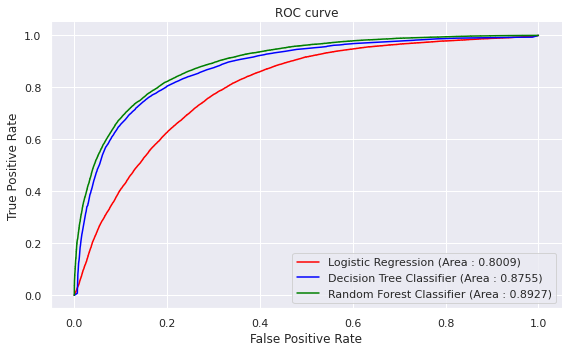

In [77]:
# your code here
import sklearn.metrics as metrics
#ROC Curve values
# plt.style.use('seaborn-white')
# plt.xkcd(randomness=0,scale=0.1)

fig, ax = plt.subplots(figsize = (8,5))
# fig.patch.set_facecolor('None')
# fig.patch.set_alpha(0)

# plot_roc(y_test,y_prob_logre,y_prob_dct, y_prob_forest, ax)
plot_roc(y_test,y_proba_logre,y_proba_dct, y_proba_forest, ax)
[ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
# ax.patch.set_facecolor('None')
# ax.patch.set_alpha(0)
plt.tight_layout()

# <b> CONCLUSION:

<b> Summarize everything we have gathered so far for all three models in Table format:

In [55]:
#Importing PrettyTable
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
table = PrettyTable(["Metric/Parameter","Logistic Regression","Decision Tree", "Random Forest"])

#Adding Rows

table.add_row(['Accuracy Score',round(acc_logre,2),round(acc_dct,2),round(acc_forest,2)])
table.add_row(['F1 Score',round(f1_logre,2),round(f1_dct,2),round(f1_forest,2)])
table.add_row(['Area Under Curve',round(auc_logre,2),round(auc_dct,2),round(auc_forest,2)])

print(table)

+------------------+---------------------+---------------+---------------+
| Metric/Parameter | Logistic Regression | Decision Tree | Random Forest |
+------------------+---------------------+---------------+---------------+
|  Accuracy Score  |         0.74        |      0.82     |      0.81     |
|     F1 Score     |         0.57        |      0.73     |      0.75     |
| Area Under Curve |         0.8         |      0.88     |      0.89     |
+------------------+---------------------+---------------+---------------+


#### <b> From observing the table, we can make an argument that  'Random Forest'  is performing the best among all of the other models. 

#### Hence, we are finnaly going to use this model only to predict on our final TEST DATASET Given by the Kaggle Higgs -Boson Challenge.

# OUR TEST DATASET

In [56]:
df_test.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,0.05,0.08,0.01,0.00,0.15,0.11,0.51,0.12,0.00,0.00,...,0.82,0.04,0,0.02,0.44,0.36,0.2,0.54,0.91,0.00
1,0.05,0.07,0.06,0.04,0.15,0.11,0.51,0.33,0.00,0.04,...,0.32,0.07,1,0.02,0.44,0.36,0.2,0.54,0.91,0.03
2,0.06,0.06,0.07,0.00,0.15,0.11,0.51,0.46,0.01,0.03,...,0.20,0.04,0,0.20,0.39,0.45,0.2,0.54,0.91,0.00
3,0.07,0.03,0.07,0.01,0.15,0.11,0.51,0.47,0.01,0.02,...,0.69,0.07,0,0.20,0.39,0.45,0.2,0.54,0.91,0.00
4,0.03,0.09,0.04,0.07,0.15,0.11,0.51,0.14,0.10,0.33,...,0.46,0.39,3,0.20,0.39,0.45,0.2,0.54,0.91,0.32


In [57]:
df_test.fillna(method = 'ffill', inplace = True)

In [58]:
# Using Trained Random Forest Model to predict on the final dataset:

x_final_test = df_test

y_final_prediction = forest.predict(x_final_test)

In [59]:
# Creating a submission dataframe: 
df_cols = ['EventId','RankOrder', 'Label']

df_submission = pd.DataFrame(columns = df_cols)
df_submission.EventId = np.arange(350000, 900000)
df_submission.Label = y_final_prediction
df_submission.RankOrder = np.arange(1,550001)

#### <b> The dataset to submit for the Kaggle Higgs- Boson Challenge

In [60]:

df_submission.head()

,EventId,RankOrder,Label
0,350000,1,0.0
1,350001,2,0.0
2,350002,3,0.0
3,350003,4,0.0
4,350004,5,0.0


<b> We need to change Lables as 0 = b and 1 = s

In [61]:
# Updating the Labels
df_submission['Label'][df_submission.Label == 0.0] ='b'
df_submission['Label'][df_submission.Label == 1.0] ='s'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
# Final dataset to submit

print("Final Submission Dataset")
df_submission.head(20)


Final Submission Dataset


,EventId,RankOrder,Label
0,350000,1,b
1,350001,2,b
2,350002,3,b
3,350003,4,b
4,350004,5,b
5,350005,6,b
6,350006,7,b
7,350007,8,b
8,350008,9,b
9,350009,10,b


In [63]:
# Checking if there is our model predicted 1 and 0 both or not. 
Counter(df_submission['Label'])

Counter({'b': 473000, 's': 77000})

In [64]:
# saving the dataframe to the local disk
df_submission.to_csv('submission.csv', index=False)

<b> Finally, we can submit this dataframe to the kaggle site. As we have no way to check the model performance on the test dataset.

# <b> Conclusions

* As far as accuracy score is concerned, Decision Tree is performing the best, but due to class imbalance, we are not going to use the accuracy score as our best performing model criteria. 
* Hence, F1_score and AUC score has been used to get the best performing model. 
* From the Table, we are concluding that Random forest is giving us the best score and AUC _score.
* This ROC Curve is giving us a clear picture of the best performing model which is the Random Forest Classifier with the highest F1_score and AUC_score.



# <b> PROJECT COMPLETED